In [1]:
from IPython.display import display

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math

from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from statsmodels.tsa.seasonal import seasonal_decompose

/var/folders/wq/8mxmhthx1qjg6pq5jr3045k40000gn/T/ipykernel_23642/1909693071.py:5: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


## Load in Data and Set Index

In [2]:
min_temp_data = pd.read_csv('/Users/ryangeygan/hacking/Datasets/daily-min-temperatures.csv')

In [3]:
min_temp_data.set_index('Date', inplace=True)
min_temp_data.index = pd.date_range(start=min_temp_data.index[0], periods=len(min_temp_data), freq='D')

## Brief EDA

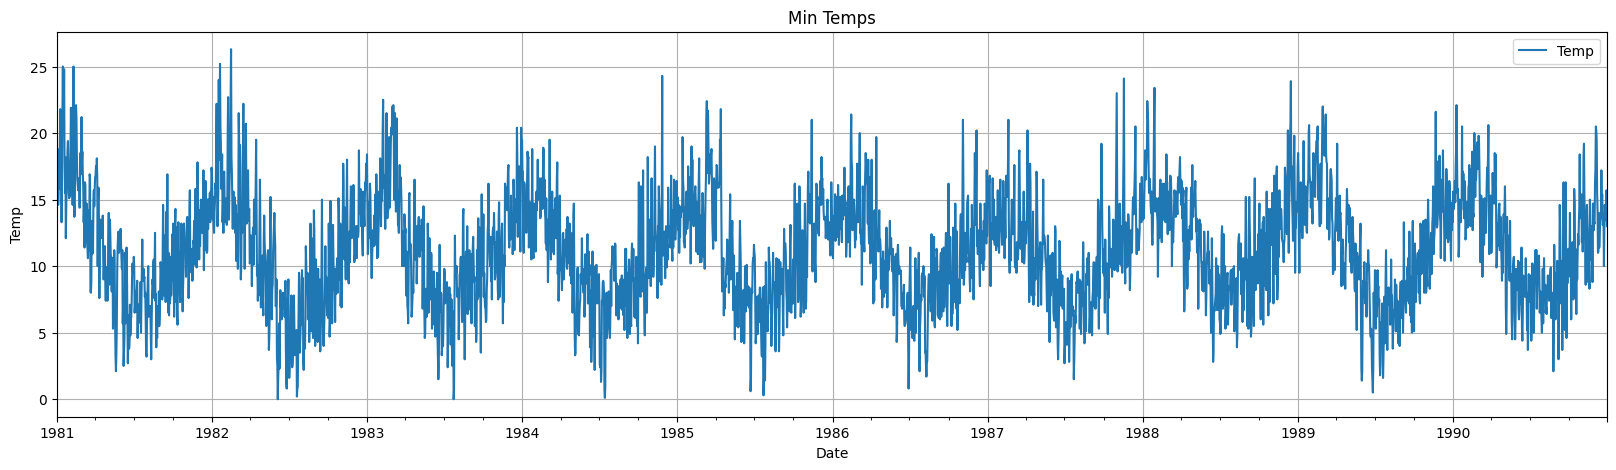

In [4]:
plt.rcParams['figure.figsize'] = [20, 5]

# Plotting
min_temp_data.plot()
plt.title('Min Temps')
plt.xlabel('Date')
plt.ylabel('Temp')
plt.grid(True)
plt.show()

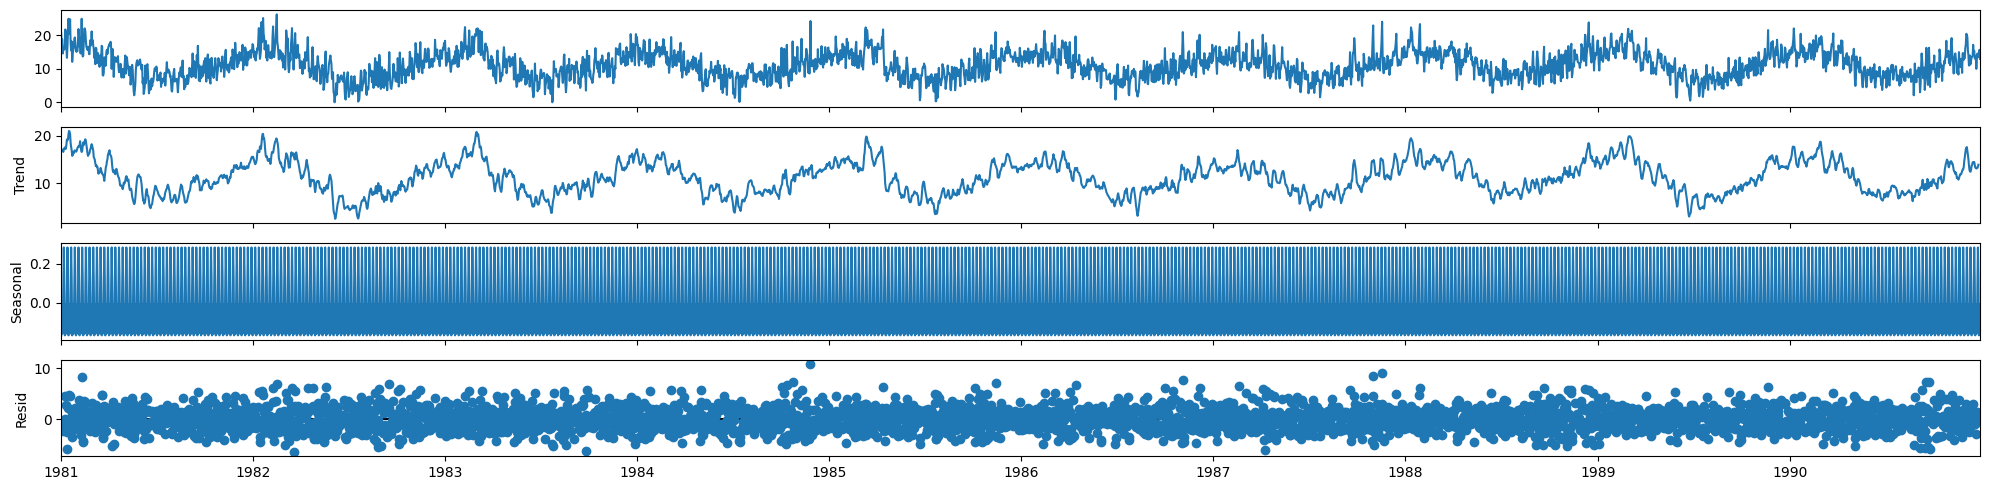

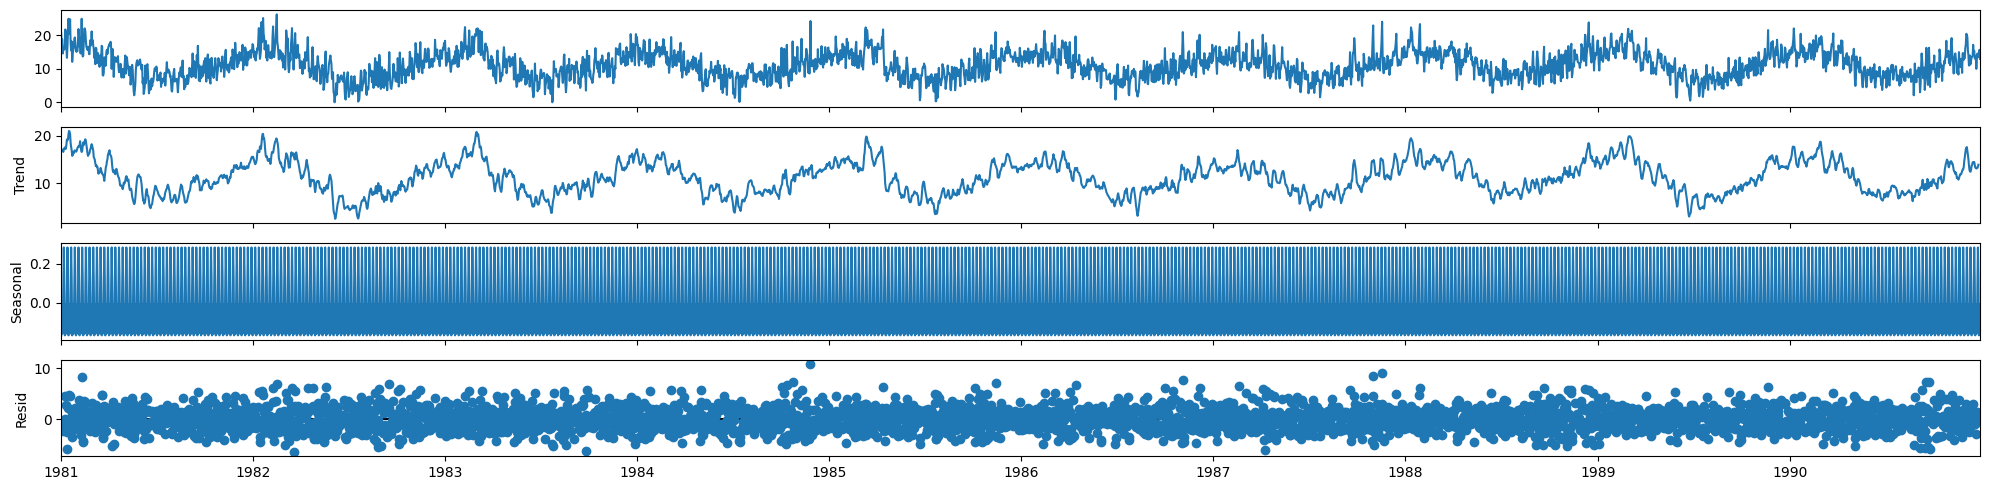

In [5]:
results = seasonal_decompose(min_temp_data)

results.plot()

## Resample the Data to Monthly and Repeat

/var/folders/wq/8mxmhthx1qjg6pq5jr3045k40000gn/T/ipykernel_23642/523218344.py:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_monthly = min_temp_data.resample('M').mean()


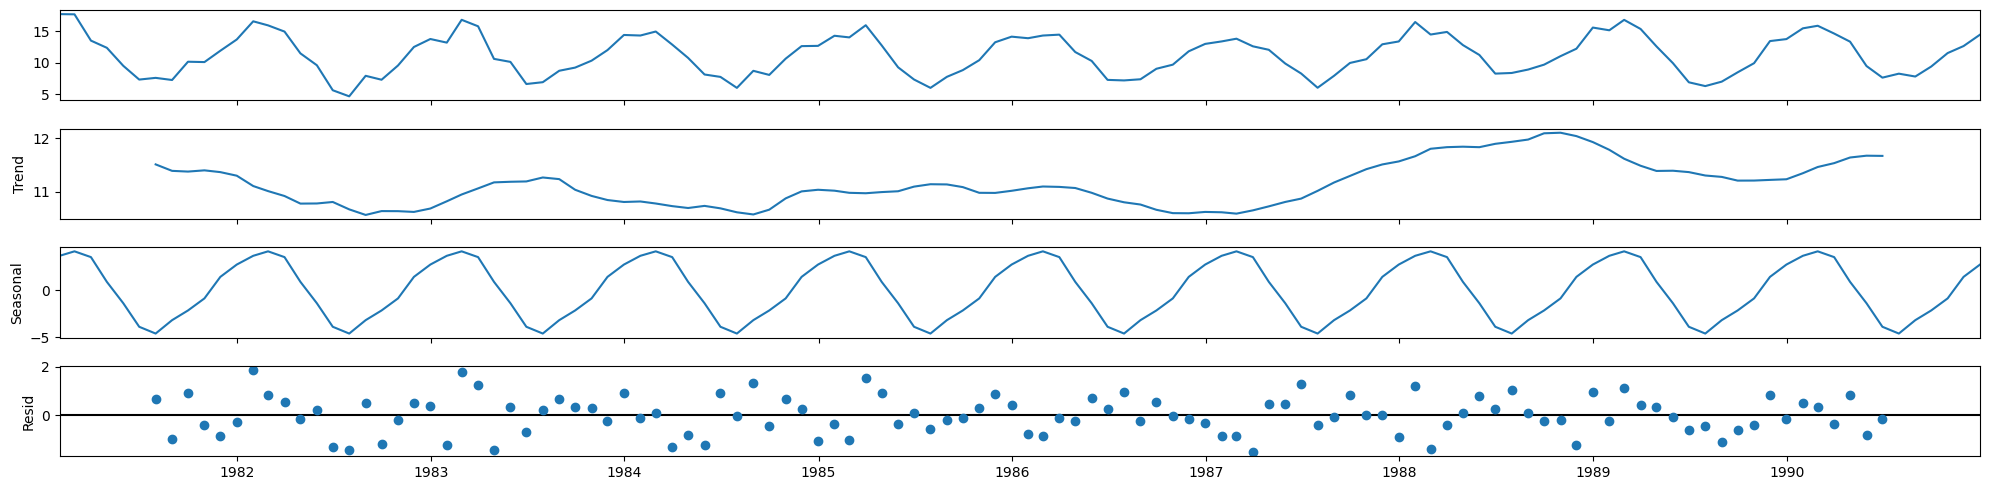

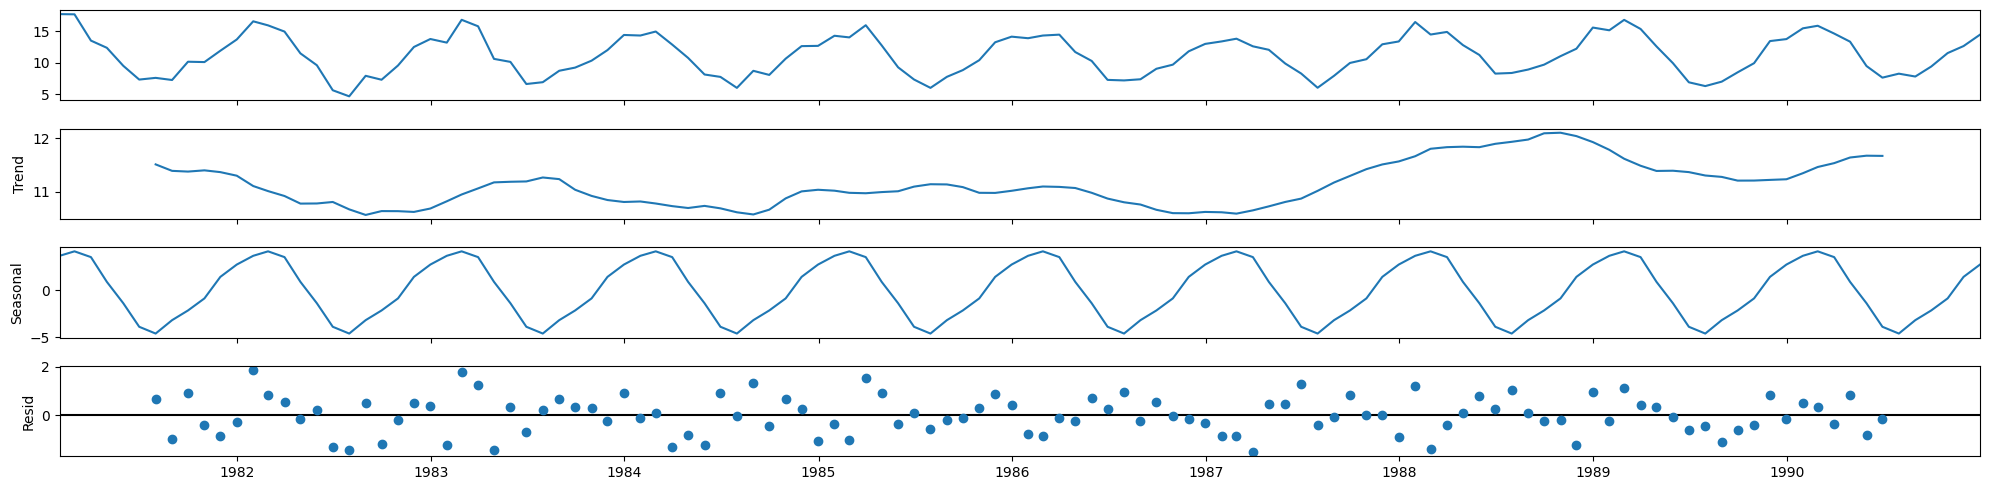

In [7]:
df_monthly = min_temp_data.resample('M').mean()

results2 = seasonal_decompose(df_monthly)

results2.plot()

## Create Training and Testing Data then Normalize Data

In [10]:
#Let's train the LSTM on 8 years of data and see how well it predicts the last two
train = df_monthly[:96]
test = df_monthly[96:]

In [11]:
# Scale data to range 0 - 1
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_train = scaler.fit_transform(train.values)
scaled_test = scaler.fit_transform(test.values)

### Define the Time Series Generator
This parses the input data into "batches" - sets of data for training. The data scientist can play with the "lookback" period which is the size of the time window for training. For example, in this daily dataset if the lookback was 365, we would be passing it batches of 365 sequential data points at a time to predict the 366th value. Then the window would move one day forward and use days 2 - 366 to predict the 367th value. Temperature has daily and yearly periodicity so it's up to the scientist to decide how to allocate computing resources. Training on larger windows creates a larger model.

In [12]:
#generator using a 30 day window
look_back = 12 #the time window
n_features = 1 #the number of predictor features (we have 1 - time)

train_generator = TimeseriesGenerator(scaled_train, scaled_train,
                                      length        = look_back, 
                                      sampling_rate = 1,
                                      stride        = 1,
                                      batch_size    = 10)

test_generator = TimeseriesGenerator(scaled_test, scaled_test,
                                      length        = look_back, 
                                      sampling_rate = 1,
                                      stride        = 1,
                                      batch_size    = 10)

# Create a Simple LSTM Model

In [13]:
#Initializie model class
model = Sequential()
model.add(Input(shape=(look_back,n_features)))
#We will only add 1 LSTM cell block because there is only 1 input feature to predict temp (time)
model.add(LSTM(150))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [14]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 150)            │        91,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           151 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 91,351 (356.84 KB)

 Trainable params: 91,351 (356.84 KB)

 Non-trainable params: 0 (0.00 B)

## Fit the Model

In [15]:
model.fit(train_generator, epochs=300)

Epoch 1/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0977  
Epoch 2/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0829 
Epoch 3/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0654 
Epoch 4/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0471 
Epoch 5/300
1/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0552

/Users/ryangeygan/hacking/machine-learning/.venv-machine-learning/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0493 
Epoch 6/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0426 
Epoch 7/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0434 
Epoch 8/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0371 
Epoch 9/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0264 
Epoch 10/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0222 
Epoch 11/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0135 
Epoch 12/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0125 
Epoch 13/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0169 
Epoch 14/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0095 
Epoch 15/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0078 
Epoch 16/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0139 
Epoch 17/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0074 
Epoch 18/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0061 
Epoch 19/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0070 
Epoch 20/300
9/9 ━━━━━━━━━━

In [18]:
test_predictions = []

first_eval_batch = scaled_train[-look_back:]
current_batch = first_eval_batch.reshape((1, look_back, n_features))

for i in range(len(test) + 24):
    
    # get the prediction value for the first batch
    current_pred = model.predict(current_batch)[0]
    
    
    # append the prediction into the array
    test_predictions.append(current_pred) 
    
    # use the prediction to update the batch and remove the first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)
     

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


In [28]:
transformed_pred = scaler.inverse_transform(test_predictions)

predictions = [x[0] for x in transformed_pred]

my_preds_list = [np.nan] * (144 - 48) + predictions

# Extend the DataFrame by 24 months
extension_dates = pd.date_range(start=df_monthly.index[-1] + pd.DateOffset(months=1), periods=24, freq='M')  # Add 24 months
extension_data = {'value': [None] * 24}  # Fill with None or NaN values, or specify your own values
extension_df = pd.DataFrame(extension_data, index=extension_dates)
extended_df = pd.concat([df_monthly, extension_df]).drop(columns=['value'])

extended_df['predicted_temp'] = my_preds_list

/var/folders/wq/8mxmhthx1qjg6pq5jr3045k40000gn/T/ipykernel_23642/1937721759.py:8: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  extension_dates = pd.date_range(start=df_monthly.index[-1] + pd.DateOffset(months=1), periods=24, freq='M')  # Add 24 months


,Temp,predicted_temp
1989-01-31,15.141935,15.325625
1989-02-28,16.796429,15.520010
1989-03-31,15.351613,14.916473
1989-04-30,12.576667,12.976119
1989-05-31,9.916129,10.432921
1989-06-30,6.873333,8.406299
1989-07-31,6.270968,7.900778
1989-08-31,6.977419,8.573620
1989-09-30,8.456667,9.876992
1989-10-31,9.912903,11.423616


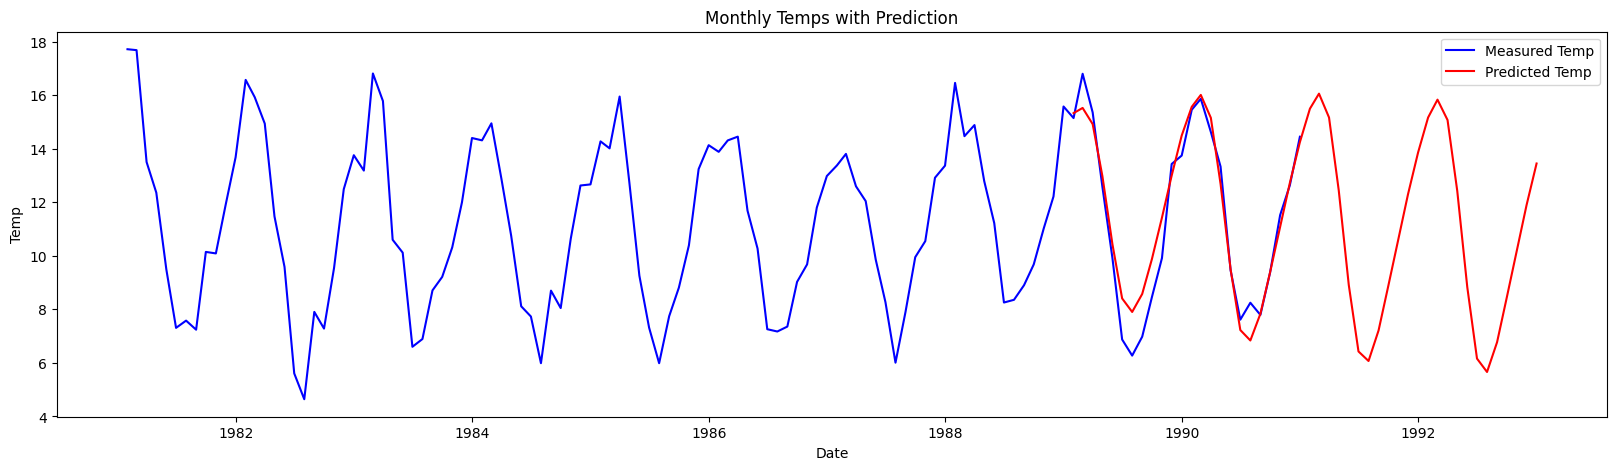

In [29]:
# Plotting
plt.rcParams['figure.figsize'] = [20, 5]

# Plot col1 in blue
plt.plot(extended_df.index, extended_df['Temp'], color='blue', label='Measured Temp')

# Plot col2 in red
plt.plot(extended_df.index, extended_df['predicted_temp'], color='red', label='Predicted Temp')

# Set labels and title
plt.xlabel('Date')
plt.ylabel('Temp')
plt.title('Monthly Temps with Prediction')
plt.legend()

# Show plot
plt.show()